<a href="https://colab.research.google.com/github/TheDandyCodes/Deep-Learning/blob/main/Excercises/GradCAM_CNN_PEC02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 14.5 MB/s eta 0:00:00


In [3]:
!pip install mlflow pyngrok --quiet

In [4]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Activation,
    Flatten,
    Dense,
    Dropout,
    GlobalAveragePooling2D
)

from tensorflow.keras.models import load_model

from tensorflow.keras.regularizers import l2

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import SGD, RMSprop, Adam

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications import VGG16

import mlflow
import mlflow.keras

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tempfile

import cv2
import os
import random

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [ ]:
mlflow.keras.autolog()  # Captures everything automatically

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

## CIFAR-10 Dataset

In [6]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Check class balance in train set

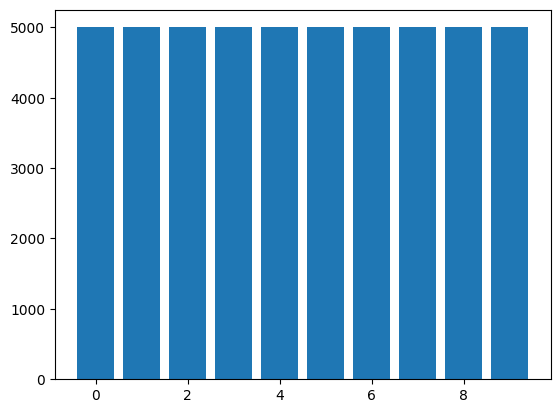

In [7]:
unique, counts = np.unique(Y_train, return_counts=True)

plt.bar(unique, counts)
plt.show()

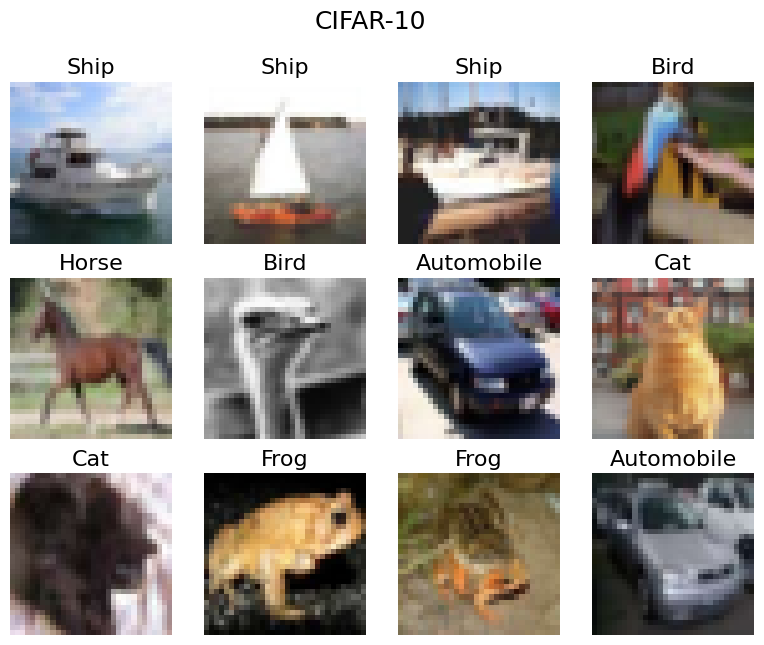

In [8]:
clases = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
plt.figure(figsize=(9.6,7.2))
plt.suptitle("CIFAR-10", size=18)
plt.subplots_adjust(wspace=0.2)

pos = 1
for n in np.random.randint(low=0,high=len(X_train),size=12):
    plt.subplot(3, 4, pos)
    plt.imshow(X_train[n])
    plt.axis('off')
    plt.title(clases[Y_train[n][0]], size=16)
    pos += 1
plt.show()

## Técnicas de análisis y preprocesamiento de datos

In [9]:
# consider them as float and normalize
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)

50000 train samples
10000 test samples


## Descripción y obtención de resultados de los diferentes modelos

### Modelo 1: CNN

Para poder determinar el modelo 1 (baseline), se realizan 6 experimentos sencillos, a partir de la arquitectura base LeNet.

Los experimentos realizados son:
1. **Experimento 1**: Lenet con optimizador Adam sin regularización
2. **Experimento 2**: Lenet con optimizador por descenso del gradiente estocástico sin regularización
3. **Experimento 3**: Lenet con optimizador Adam y dropout
4. **Experimento 4**: Lenet con optimizador por descenso del gradiente estocástico y dropout
5. **Experimento 5**: Lenet con optimizador Adam y regularización L2
6. **Experimento 6**: Lenet con optimizador por descenso del gradiente estocástico y regularización L2

Para la experimentación, la visualización de los resultados y su comparación, se hace uso de `MLflow`.

In [ ]:
from dataclasses import dataclass

@dataclass
class Experiment:
  name: str
  optimizer: str
  learning_rate: float
  dropout: float
  l2: float
  architecture: str

In [ ]:
experiments = [
    Experiment("baseline_lenet_adam", "adam", 1e-3, 0.0, 0.0, "lenet"),
    Experiment("baseline_lenet_sgd", "sgd", 1e-3, 0.0, 0.0, "lenet"),
    Experiment("lenet_dropout_adam", "adam", 1e-3, 0.5, 0.0, "lenet"),
    Experiment("lenet_dropout_sgd", "sgd", 1e-3, 0.5, 0.0, "lenet"),
    Experiment("lenet_l2_adam", "adam", 1e-3, 0.0, 1e-4, "lenet"),
    Experiment("lenet_l2_sgd", "sgd", 1e-3, 0.0, 1e-4, "lenet")
]

In [ ]:
class Model1:
    @staticmethod
    def build(architecture="lenet", input_shape=(32, 32, 3), classes=10, dropout=0.0, l2_value=0.0):
        model = Sequential()
        model.add(Input(shape=input_shape))
        if architecture == "lenet":
          model.add(Conv2D(6, kernel_size=5, padding="same", kernel_regularizer=l2(l2_value)))
          model.add(Activation("relu"))
          model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
          model.add(Conv2D(16, kernel_size=5, padding="same", kernel_regularizer=l2(l2_value)))
          model.add(Activation("relu"))
          model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
          model.add(Conv2D(120, kernel_size=5, padding="same", kernel_regularizer=l2(l2_value)))
          model.add(Activation("relu"))
          model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
          model.add(Flatten())
          if dropout > 0.0:
            model.add(Dropout(dropout))
          model.add(Dense(84))
          model.add(Activation("relu"))
          model.add(Dense(classes))
          model.add(Activation("sigmoid")) # Multi-Class Classification
        return model

#### Training

In [10]:
NB_EPOCH = 150
BATCH_SIZE = 128
VERBOSE = 1
VALIDATION_SPLIT=0.2

IMG_ROWS, IMG_COLS = X_train.shape[1], X_train.shape[2]
NB_CLASSES = Y_train.shape[1]

INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 3)

In [ ]:
def train(experiment: Experiment, X_train, Y_train, X_test, Y_test, callbacks):
    with mlflow.start_run(run_name=experiment.name) as run:
        model1 = Model1.build(
          input_shape=INPUT_SHAPE,
          classes=NB_CLASSES,
          architecture=experiment.architecture,
          dropout=experiment.dropout,
          l2_value=experiment.l2
        )

        model1.summary()

        if experiment.optimizer == "adam":
            optimizer = Adam(learning_rate=experiment.learning_rate)
        elif experiment.optimizer == "sgd":
            optimizer = SGD(learning_rate=experiment.learning_rate)

        model1.compile(
            loss="categorical_crossentropy",
            optimizer=optimizer,
            metrics=["accuracy"]
        )

        history = model1.fit(
            X_train,
            Y_train,
            batch_size=BATCH_SIZE,
            epochs=NB_EPOCH,
            verbose=VERBOSE,
            validation_split=VALIDATION_SPLIT,
            callbacks=callbacks
        )

        ## Test
        Y_pred_probs = model1.predict(X_test)
        Y_pred = Y_pred_probs.argmax(axis=1)
        # real classes converted from one-hot
        Y_true = np.argmax(Y_test, axis=1)

        # Test F1-score, Precision, Recall macro
        f1_macro = f1_score(Y_true, Y_pred, average='macro')
        precision = precision_score(Y_true, Y_pred, average='macro')
        recall = recall_score(Y_true, Y_pred, average='macro')
        accuracy = accuracy_score(Y_true, Y_pred)

        # Log to MLflow
        mlflow.log_metric("test_f1_macro", f1_macro)
        mlflow.log_metric("test_precision_macro", precision)
        mlflow.log_metric("test_recall_macro", recall)
        mlflow.log_metric("test_accuracy", accuracy)

        print(f"Run terminado: {experiment.name} (run_id={run.info.run_id})")

    return history, model1

In [ ]:
import subprocess

# Launch MLflow in the background
mlflow_ui = subprocess.Popen(["mlflow", "ui", "--port", "5000"])

[2025-06-11 19:25:31 +0000] [122] [INFO] Starting gunicorn 23.0.0
[2025-06-11 19:25:31 +0000] [122] [INFO] Listening at: http://127.0.0.1:5000 (122)
[2025-06-11 19:25:31 +0000] [122] [INFO] Using worker: sync
[2025-06-11 19:25:31 +0000] [123] [INFO] Booting worker with pid: 123
[2025-06-11 19:25:31 +0000] [124] [INFO] Booting worker with pid: 124
[2025-06-11 19:25:31 +0000] [125] [INFO] Booting worker with pid: 125
[2025-06-11 19:25:31 +0000] [126] [INFO] Booting worker with pid: 126


Para poder visualizar los experimentos registrados en MLflow a través del navegador del ordenador local

In [ ]:
from pyngrok import conf, ngrok

conf.get_default().auth_token = "2yDzcxJr6BzN4Tl5TdodBZhVbj4_5hGH4TA8PNRBnuMWd5hwJ"

mlflow_port = 5000

# Opens public tunnel to that port
public_url = ngrok.connect(mlflow_port)
print(f"🔗 MLflow UI disponible en: {public_url}")

🔗 MLflow UI disponible en: NgrokTunnel: "https://abd5-34-19-126-227.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
## To close the tunnel and the process on completion
# mlflow_ui.terminate()
# ngrok.kill()

Para el entrenamiento, se utilizan dos callbacks. Uno que evita el overfitting a través del Early Stopping y otro para el guardado del modelo (checkpoint) con mejor resultado en el accuracy del validation set.

In [ ]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,  # Restores the weights of the best model
    mode='max',
    verbose=1
)

In [ ]:
mlflow.set_experiment("Model1_CIFAR10")

for exp in tqdm(experiments, ""):
    import os

    model_dir = 'models/model1/'

    if not os.path.exists(model_dir):
      os.makedirs(model_dir, exist_ok=True)

    checkpoint = ModelCheckpoint(
        filepath=f'{model_dir}/{exp.name}.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max', # the Higher the Acuraccy, better
        verbose=1
    )

    print(f"Ejecutando experimento: {exp.name}")
    history, model = train(
        exp,
        X_train,
        Y_train,
        X_test,
        Y_test,
        [early_stop, checkpoint]
    )

  0%|          | 0/1 [00:00<?, ?it/s]

Ejecutando experimento: lenet_dropout_adam


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 6)           │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 32, 32, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 120)           │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 8, 8, 120)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 120)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 84)                  │         161,364 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 213,206 (832.84 KB)

 Trainable params: 213,206 (832.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2735 - loss: 1.9742
Epoch 1: val_accuracy improved from -inf to 0.45480, saving model to models/model1//lenet_dropout_adam.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.2737 - loss: 1.9736 - val_accuracy: 0.4548 - val_loss: 1.5070
Epoch 2/150
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4521 - loss: 1.4995
Epoch 2: val_accuracy improved from 0.45480 to 0.50420, saving model to models/model1//lenet_dropout_adam.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4522 - loss: 1.4992 - val_accuracy: 0.5042 - val_loss: 1.3800
Epoch 3/150
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5058 - loss: 1.3735
Epoch 3: val_accuracy improved from 0.50420 to 0.53730, saving model to models/model1//lenet_dropout_adam.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5058 - loss: 1.3734 - val_accuracy: 0.5373 - val_loss: 1.3013
Epoch 4/150
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy

100%|██████████| 1/1 [01:07<00:00, 67.33s/it]

Run terminado: lenet_dropout_adam (run_id=32d2b8bdb2d64cc4a0cd22d6e876962f)


#### Load Selected Model

Para determinar que modelo seleccionar de los 6 experimentos realiados, se revisan las métricas en la interfaz de `MLflow`

**Primero comparamos la evolución del accuracy en el conjunto de validación**

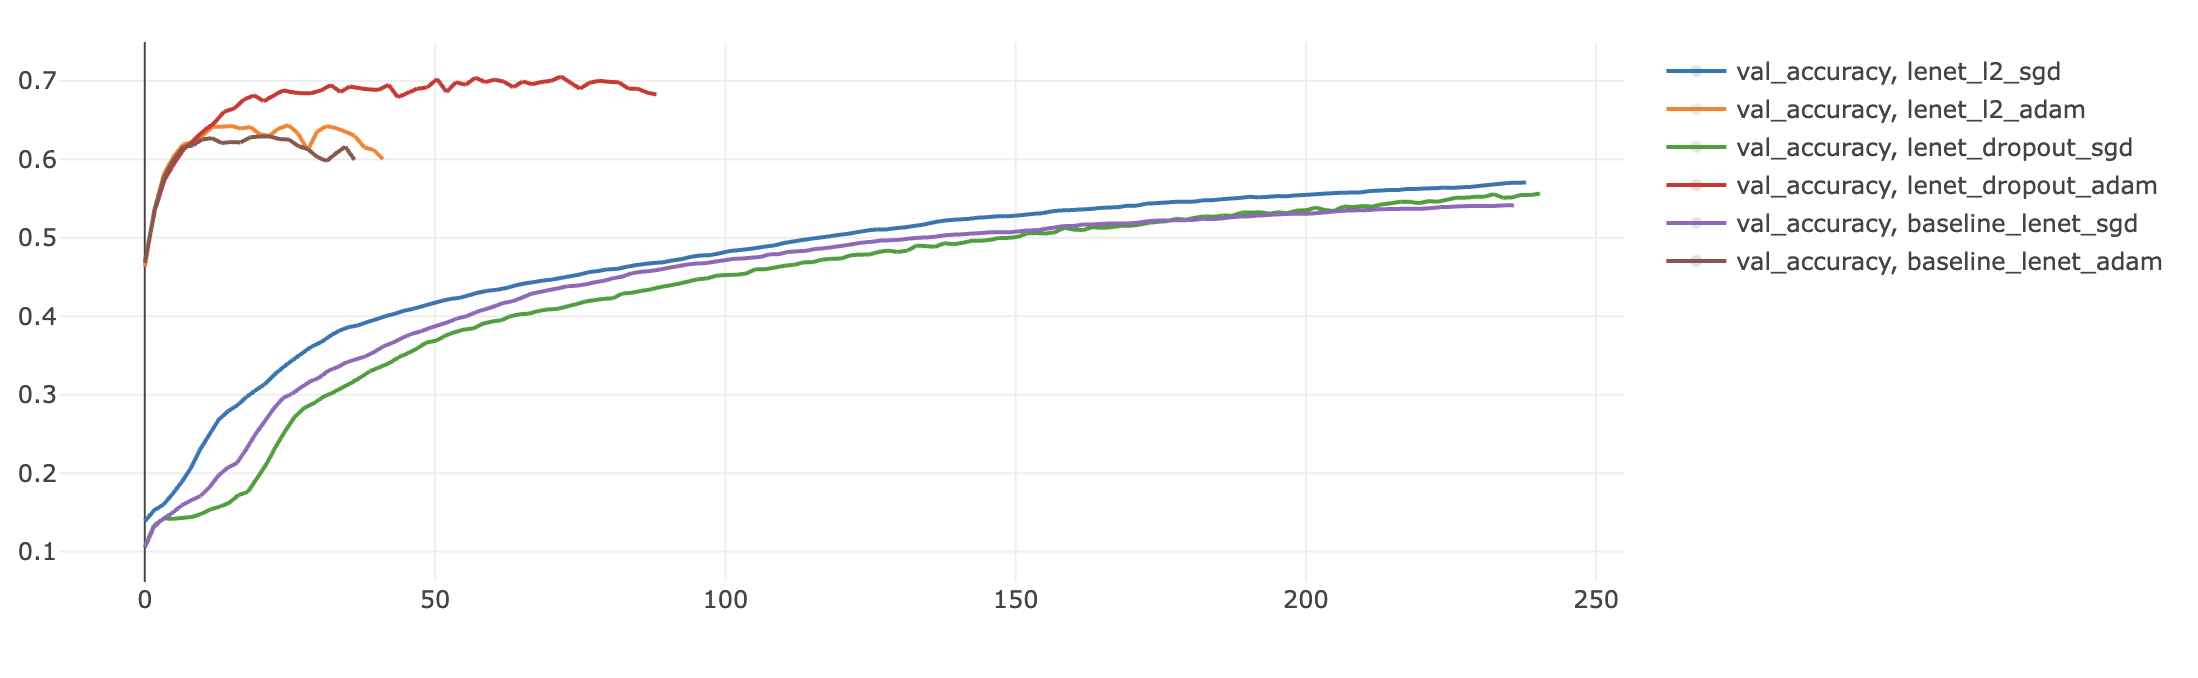

Se observa como los modelos con optimizador adam, convergen mucho más rapido que los que utilizan el descenso del gradiente estocástico. Dentro de estos experimentos, el que resulta en una mayor accuracy del conjunto de validación al final de su entrenamiento corresponde al **Experimento 3**; entrenado con droput para reducir el overfitting (*high variance & low bias*)

**Realizamos este mismo análisis con la pérdida del conjunto de validación durante el entrenamiento**

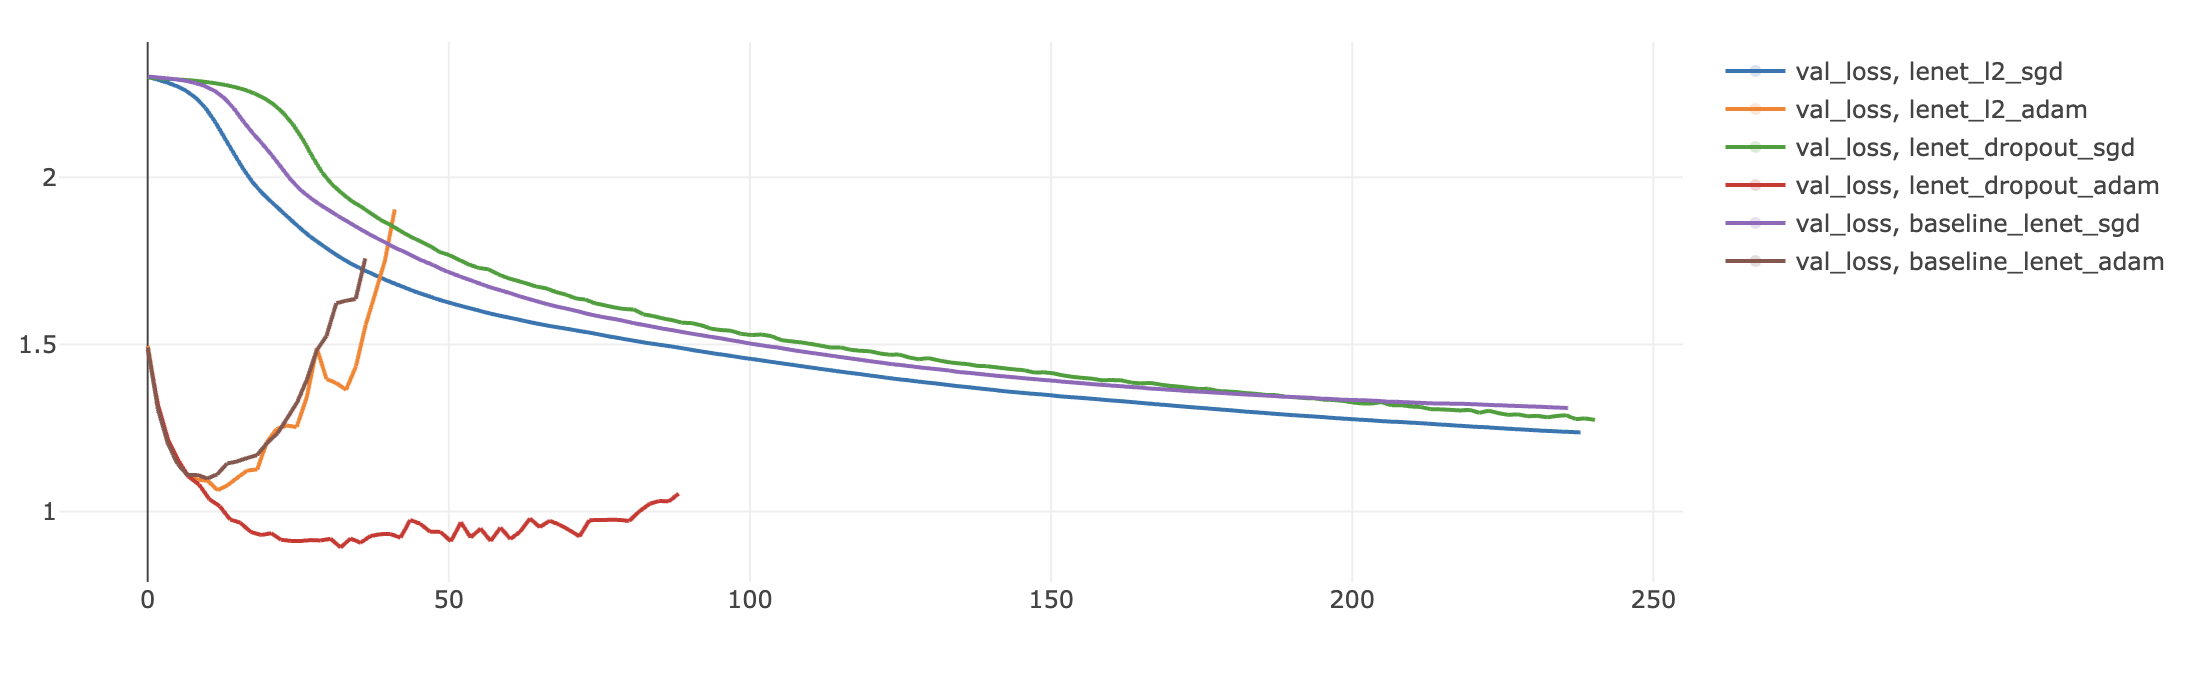

Aqui se ve de manera más evidente el overfitting de los modelos entrenados con optimizador adam (convergen antes) y usando regularización L2, mientras que otro se entrena sin regularización.

El modelo que mejor resultados produce durante el entrenamiento corresponde al mismo que antes, LeNet con adam y dropout. Este modelo presenta mayor estabilidad en el entrenamiento, comparado con sus compañeros entrenados con Adam, y converge en una mejor solución (según la pérdida observada) frente a los modelos que se entrenan con descenso del gradiente estocástico.

**Otro análisis pertinente corresponde a comparar F1-Score en el conjunto test**

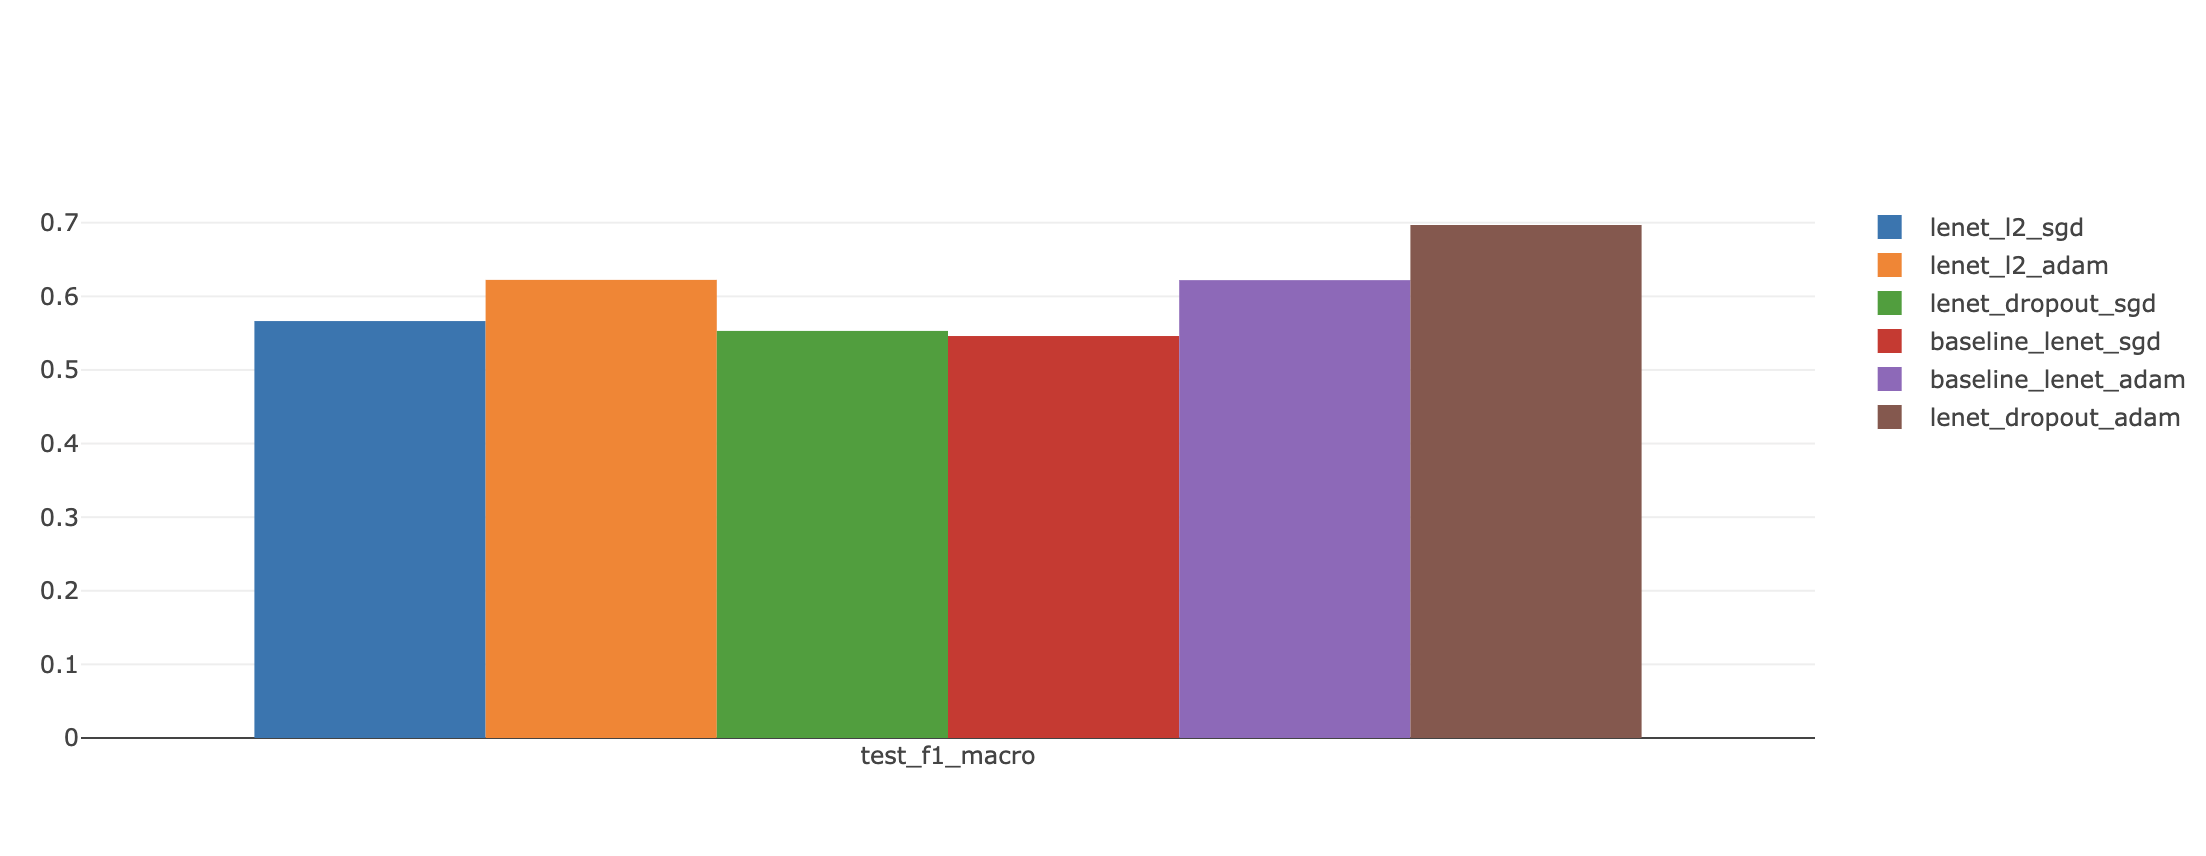

Se observa como claramente, el mismo modelo de antes, presenta el mejor valor de la métrica F1-Score sobre el conjunto test.

**Un último análisis compara los optimizadores utilizados con el resultado en las métricas Accuracy, Recall, F1-Score y Precisión (macro average) sobre el conjunto test**

Captura de pantalla 2025-06-09 a las 10.24.15 p. m..png

Este diagrama de *parallel coordinates* ofrece una visión clara de la diferencia de usar Adam frente a SGD para este problema.

También se hace evidente que el mismo modelo que en los análisis anteriores ofrece las mejores métricas sobre el conjunto test

**Como conclusión**

Se decide escoger el modelo LeNet entrenado con Adam y dropout

In [10]:
from tensorflow.keras.models import load_model

baseline_model = load_model('/content/models/model1/lenet_dropout_adam.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Clase predicha: Truck
Clase real: Truck


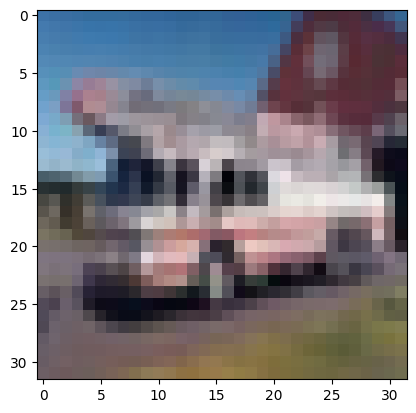

In [12]:
from PIL import Image
import random

idx = random.randint(0, len(X_test) - 1)

test_img = X_test[idx]
img_batch = X_test[idx:idx+1]

preds = baseline_model.predict(img_batch)
pred = np.argmax(preds)

print(f"Clase predicha: {clases[pred]}")
print(f"Clase real: {clases[np.argmax(Y_test[idx])]}")
# show img
plt.imshow(test_img)
plt.show()

In [13]:
preds = baseline_model.predict(X_test)
predicted_clases = preds.argmax(axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(Y_test.argmax(axis=1), predicted_clases)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Este modelo de base presenta unas pequeñas dificultades en la predicción de la clase Gato. También se pueden ver ejemplos donde, aunque no muy frecuente, el modelo confunde los vehículos; ya sea avión, coche, caminón y barco.

In [15]:
from sklearn.metrics import classification_report
print(classification_report(Y_test.argmax(axis=1), predicted_clases))

              precision    recall  f1-score   support

           0       0.70      0.80      0.75      1000
           1       0.83      0.79      0.81      1000
           2       0.58      0.61      0.59      1000
           3       0.56      0.40      0.47      1000
           4       0.65      0.62      0.63      1000
           5       0.58      0.60      0.59      1000
           6       0.72      0.79      0.76      1000
           7       0.70      0.78      0.74      1000
           8       0.83      0.78      0.81      1000
           9       0.73      0.76      0.75      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



### Modelo 2: Transfer Learning

Se selecciona el modelo VGG16 de Keras Applications ya que la top-k precision de 90.1% y es un modelo con una arquitectura sencilla

In [11]:
# Resize on the fly
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    return image, label

def create_dataset(X, Y, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X))
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

def get_base_model():
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    return base_model

def build_model(base_model):
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')

    ])
    return model

def train_model(model, X_train, Y_train, callbacks, epochs, experiment_name):
    X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
        X_train, Y_train, test_size=0.2, stratify=Y_train, random_state=42
    )
    train_ds = create_dataset(X_train_split, Y_train_split, batch_size=32)
    val_ds = create_dataset(X_val_split, Y_val_split, batch_size=32, shuffle=False)

    with mlflow.start_run(run_name=experiment_name) as run:
    ## Compile and train
        model.compile(
            optimizer="adam",
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )

        model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            batch_size=BATCH_SIZE,
            verbose=VERBOSE,
            callbacks=[callbacks]
        )

        test_ds = create_dataset(X_test, Y_test)
        ## Test
        Y_pred_probs = model.predict(test_ds)
        Y_pred = Y_pred_probs.argmax(axis=1)
        # real classes converted from one-hot
        Y_true = np.argmax(Y_test, axis=1)

        # Test F1-score, Precision, Recall macro
        f1_macro = f1_score(Y_true, Y_pred, average='macro')
        precision = precision_score(Y_true, Y_pred, average='macro')
        recall = recall_score(Y_true, Y_pred, average='macro')
        accuracy = accuracy_score(Y_true, Y_pred)

        # Log to MLflow
        mlflow.log_metric("test_f1_macro", f1_macro)
        mlflow.log_metric("test_precision_macro", precision)
        mlflow.log_metric("test_recall_macro", recall)
        mlflow.log_metric("test_accuracy", accuracy)

        print(f"Run terminado: {experiment_name} (run_id={run.info.run_id})")

        return model


def transfer_learning(X_train, Y_train, callbacks, experiment_name, epochs=10):

    base_model = get_base_model()
    base_model.trainable = False
    model = build_model(base_model)

    return train_model(model, X_train, Y_train, callbacks, epochs, experiment_name)

def fine_tune(model, X_train, Y_train, callbacks, experiment_name, epochs=5, unfreeze_layers=4):

    base_model = model.layers[0]
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    return train_model(model, X_train, Y_train, callbacks, epochs, experiment_name)


In [12]:
test_ds = create_dataset(X_test, Y_test)

#### Training

In [ ]:
mlflow.set_experiment("Model2_CIFAR10")

model_transfer = transfer_learning(X_train, Y_train, [early_stop], "transfer-learning")
model_transfer.save("models/model2/vgg16_transfer.h5")

#### Load Model

In [21]:
model_transfer = load_model("models/model2/vgg16_transfer.h5")

In [ ]:
idx = random.randint(0, len(X_test) - 1)

img = tf.convert_to_tensor(X_test[idx], dtype=tf.float32)
test_img = tf.expand_dims(img, axis=0)
test_img = tf.image.resize(test_img, (224, 224))

preds = model_transfer.predict(test_img)
pred = np.argmax(preds)

print(f"Clase predicha: {clases[pred]}")
print(f"Clase real: {clases[np.argmax(Y_test[idx])]}")
# show img
plt.imshow(X_test[idx])
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Clase predicha: Airplane
Clase real: Airplane


In [39]:
## Test
Y_pred_probs = model_transfer.predict(test_ds)
Y_pred = Y_pred_probs.argmax(axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 51s 163ms/step


In [40]:
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [42]:
# Classification report con las predicciones de model_transfer
print(classification_report(Y_test.argmax(axis=1), Y_pred))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70      1000
           1       0.75      0.68      0.71      1000
           2       0.59      0.51      0.55      1000
           3       0.39      0.52      0.45      1000
           4       0.53      0.62      0.57      1000
           5       0.66      0.37      0.47      1000
           6       0.64      0.66      0.65      1000
           7       0.72      0.61      0.66      1000
           8       0.77      0.74      0.76      1000
           9       0.66      0.82      0.73      1000

    accuracy                           0.63     10000
   macro avg       0.64      0.63      0.62     10000
weighted avg       0.64      0.63      0.62     10000



De manera resumida, el modelo entrenado a través de Transfer-learning, presenta una calidad preditiva sutilmente más baja a la del modelo base escogido anteriormente, con un macro accuracy sobre el conjunto test de 0.63 (igual que el modelo base).

### Modelo 3: Fine-Tuning

#### Training

In [ ]:
mlflow.set_experiment("Model3_CIFAR10")

# Keras models are mutable objetcs in python.
# Therefore, loading the model makes it a new object in memory
model_finetuned = load_model("models/model2/vgg16_transfer.h5") # VGG16 Transfer Learning Model
model_finetuned = fine_tune(
    model_finetuned,
    X_train,
    Y_train,
    [early_stop],
    "fine-tuning",
    epochs=10,
    unfreeze_layers=2)
model_finetuned.save("models/model3/vgg16_fine.h5")

#### Load Model

In [18]:
model_finetuned = load_model("models/model3/vgg16_fine.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
Clase predicha: Ship
Clase real: Ship


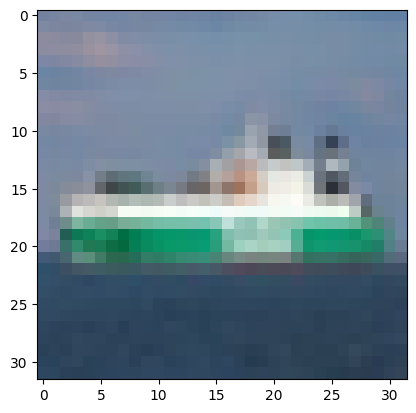

In [ ]:
idx = random.randint(0, len(X_test) - 1)

img = tf.convert_to_tensor(X_test[idx], dtype=tf.float32)
test_img = tf.expand_dims(img, axis=0)
test_img = tf.image.resize(test_img, (224, 224))

preds = model_finetuned.predict(test_img)
pred = np.argmax(preds)

print(f"Clase predicha: {clases[pred]}")
print(f"Clase real: {clases[np.argmax(Y_test[idx])]}")
# show img
plt.imshow(X_test[idx])
plt.show()

In [44]:
## Test
Y_pred_probs = model_finetuned.predict(test_ds)
Y_pred = Y_pred_probs.argmax(axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 167ms/step


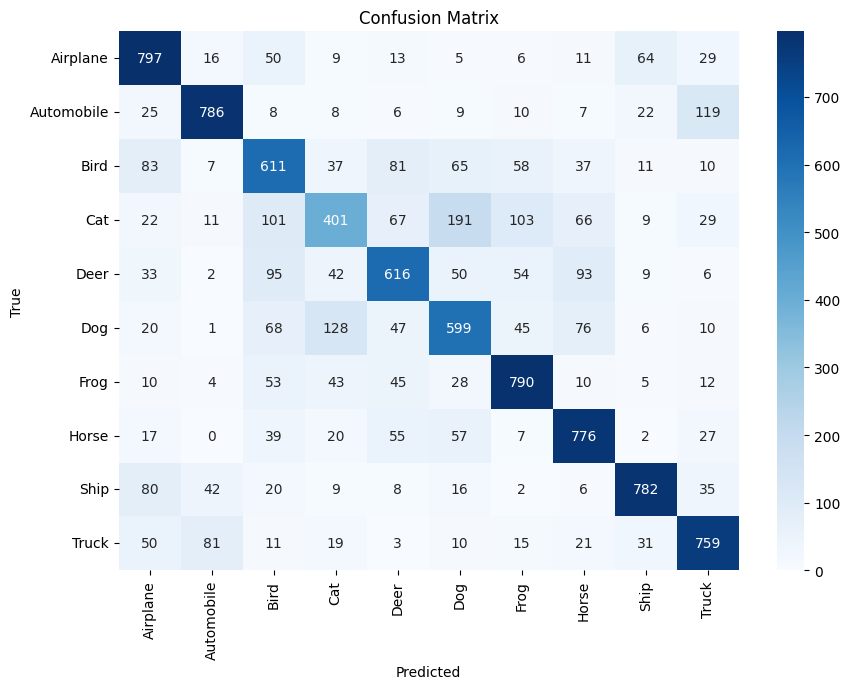

In [45]:
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [46]:
print(classification_report(Y_test.argmax(axis=1), Y_pred))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1000
           1       0.89      0.87      0.88      1000
           2       0.75      0.72      0.73      1000
           3       0.74      0.53      0.62      1000
           4       0.72      0.79      0.75      1000
           5       0.72      0.70      0.71      1000
           6       0.77      0.85      0.81      1000
           7       0.82      0.84      0.83      1000
           8       0.87      0.88      0.88      1000
           9       0.86      0.90      0.88      1000

    accuracy                           0.80     10000
   macro avg       0.79      0.80      0.79     10000
weighted avg       0.79      0.80      0.79     10000



Lo que se observa es que este modelo es el que mayor capacidad tiene a la hora de predecir las clases para el conjunto CIFAR-10. A diferencia de los modelos anteriores, el modelo entrenado a través de fine-tuning ofrece una accuracy macro del 80%, lo que equivale a un aumento del 15% en esta métrica.

### Análisis general de los modelos

En resumen, se puede exponer un podio de los tres modelos:
- Top 1: Modelo entrenado con *fine-tuning*
   - Accuracy: 80%
- Top 2: Modelo Baseline entrenado con *LeNet, Adam y Dropout*
   - Accuracy: 69%
- Top 3: Modelo entrenado con *transfer learning*
   - Accuracy: 63%

Todos ellos muestran dificultades a la hora de clasificar las clases 3 (Gato) y 5 (Perro). Posiblemente por su similitud. Esto se puede obserar en las matrices de correlación, ya que las clases que deberían ser gato, son clasificadas frecuentemente como perro y viceversa.

Dado que las clases estan perfectamente balanceadas en este dataset, la métrica de accuracy presenta menos riesgo de sesgo a la hora de interpretar la calidad predictiva de los modelos.

**Finalmente, el modelo seleccionado para realizar las visualizaciones con GradCAM será el entrenado con fine tuning**

## GradCAM

In [19]:
def apply_gradcam(model, image, class_index=None, last_conv_layer_name="block5_conv3"):
    # Model VGG16 inside your model
    base_model = model.get_layer("vgg16")

    # Creates a model from the input to the desired layer
    conv_layer_model = tf.keras.Model(
        inputs=base_model.input,
        outputs=base_model.get_layer(last_conv_layer_name).output
    )

    # Calculate gradients with respect to the objective class
    with tf.GradientTape() as tape:
        # Get activations of the latest conv and make full prediction
        conv_output = conv_layer_model(image)
        tape.watch(conv_output)

        x = model.layers[1](conv_output)  # global average pooling
        x = model.layers[2](x)            # dense 256
        x = model.layers[3](x)            # dropout
        preds = model.layers[4](x)        # dense 10

        if class_index is None:
            # Use predicted class
            class_index = tf.argmax(preds[0])

        class_output = preds[:, class_index]

    # Mean of gradients per channel
    grads = tape.gradient(class_output, conv_output)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Multiply filters by mean gradients
    conv_output = conv_output[0]
    # For each positio (i, j), weighted sum is done to the C values channels (One per channel)
    # where the weight per channel is pooled_grads[c]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)

    # Normalize heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

In [30]:
def overlay_gradcam_on_image(
    img: tf.Tensor | np.ndarray,
    heatmap: np.ndarray,
    alpha: float = 0.4,
    colormap: int = cv2.COLORMAP_JET,
    return_only: bool = False
):
    if isinstance(img, tf.Tensor):
        img = img.numpy()

    if not isinstance(img, np.ndarray):
        raise TypeError("img debe ser un tf.Tensor o np.ndarray ya preprocesado")

    if img.ndim == 4:
        img = img[0]  # remove batch dimension

    # If the image is in range [0, 1], we take it to [0, 255].
    if img.max() <= 1.0:
        img = img * 255.0

    img = np.uint8(img)

    # Make sure size is 244, 244
    img = cv2.resize(img, (224, 224))

    # Convert RGB to BGR for OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Resize heatmap
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, colormap)

    # Overlay heatmap with image
    superimposed_img = cv2.addWeighted(heatmap_color, alpha, img, 1 - alpha, 0)
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    if return_only:
      return superimposed_img_rgb
    else:
      # Show superimposed image
      plt.figure(figsize=(6, 6))
      plt.imshow(superimposed_img_rgb)
      plt.axis('off')
      plt.title('Grad-CAM Overlay')
      plt.show()

In [31]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_image_from_path(img_path):
  """Preprocess image that comes from a path."""
  img = load_img(img_path, target_size=(224, 224)) # Load as PIL img and resixe to [244, 244]
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0) # Shape: [224, 224, 3] -> [1, 224, 224, 3]
  return img_array

In [37]:
def show_gradcam_on_image(img: str | tf.Tensor, return_only: bool, verbose: bool = False):
  if isinstance(img, str):
    test_img = preprocess_image_from_path(img)
    clase_real = os.path.basename(img).split(".")[0]

  elif isinstance(img, tf.Tensor):
    test_img = img
    clase_real = clases[np.argmax(Y_test[idx])]

  preds = model_finetuned.predict(test_img)
  pred = np.argmax(preds)

  if verbose:
    print("Clase predicha:", clases[pred])
    print("Clase real:", clase_real)


  heatmap = apply_gradcam(model_finetuned, test_img, class_index=pred)

  result_img = overlay_gradcam_on_image(
      img=test_img,
      heatmap=heatmap,
      colormap=cv2.COLORMAP_TURBO,
      alpha=0.3,
      return_only=return_only
  )

  if return_only:
    return result_img


### Visualización con GradCAM

In [21]:
# Remove last layer's softmax.
# We want logits because they preserve direct linear relationships
# between activations and classes, allowing gradients to accurately
# reflect which parts of the image contribute to a class,
# without distortions introduced by softmax.
model_finetuned.layers[-1].activation = tf.keras.activations.linear
model_finetuned.compile()

#### Load image from test set

Aquí se muestra un resultado de la aplicación de GradCAM sobre una de las imagenes del conjunto test de CIFAR-10.

In [26]:
idx = random.randint(0, len(X_test) - 1)

img = tf.convert_to_tensor(X_test[idx], dtype=tf.float32)
test_img = tf.expand_dims(img, axis=0)
test_img = tf.image.resize(test_img, (224, 224))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
Clase predicha: Bird
Clase real: Bird


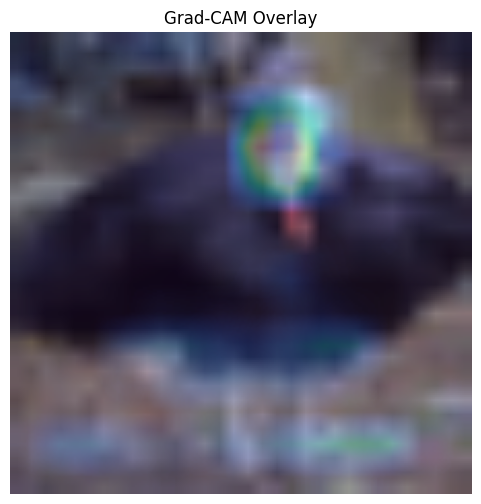

In [27]:
show_gradcam_on_image(test_img, verbose=True)

#### Load image from path

Dado que las imágenes de CIFAR-10 tienen baja resolución y a menudo cuesta diferenciar que es lo que aparece en la imagen, incluso para el ojo humano, se ha probado a realizar predicciones sobre imágenes de internet para clases pertenecientes a CIFAR-10.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Clase predicha: Truck
Clase real: truck


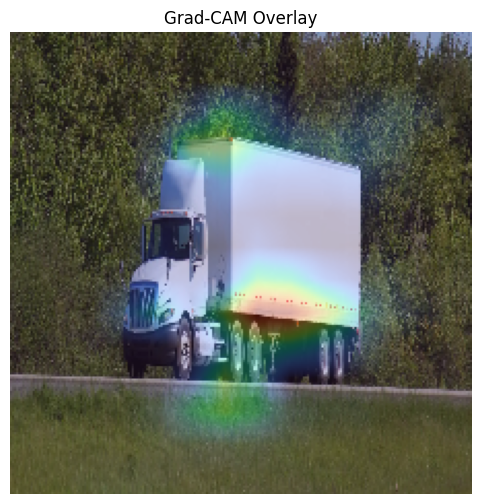

In [ ]:
show_gradcam_on_image("/content/images/truck.webp", verbose=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Clase predicha: Frog
Clase real: frog


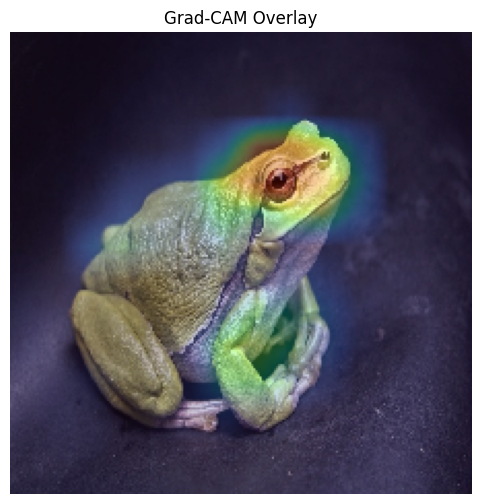

In [ ]:
show_gradcam_on_image("/content/images/frog.jpg", verbose=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
Clase predicha: Horse
Clase real: horse


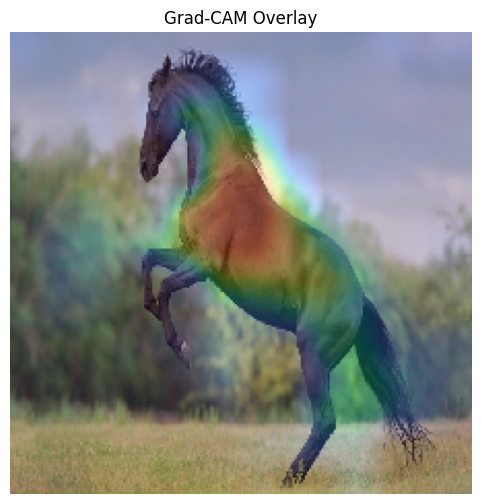

In [47]:
show_gradcam_on_image("/content/images/horse.jpg", verbose=True, return_only=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
Clase predicha: Cat
Clase real: cat


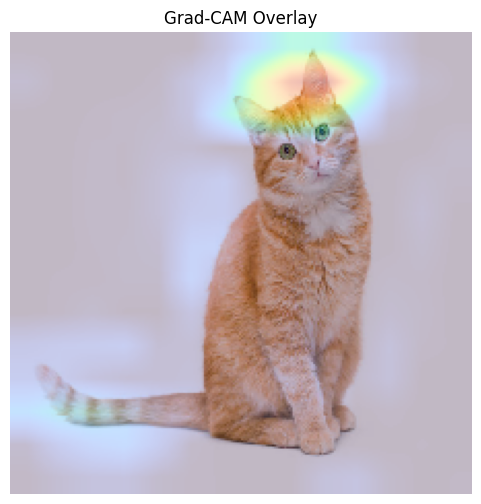

In [49]:
show_gradcam_on_image("/content/images/cat.jpg", verbose=True, return_only=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
Clase predicha: Airplane
Clase real: airplane


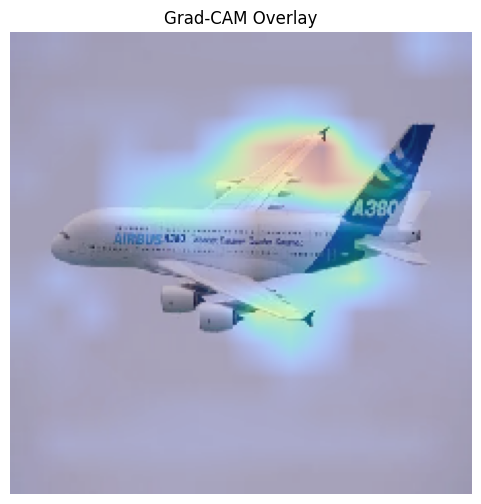

In [ ]:
show_gradcam_on_image("/content/images/airplane.webp", verbose=True)

**A continuación, se hace una comparativa de GradCAM para tres imñagenes de cada clase de CIFAR-10**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

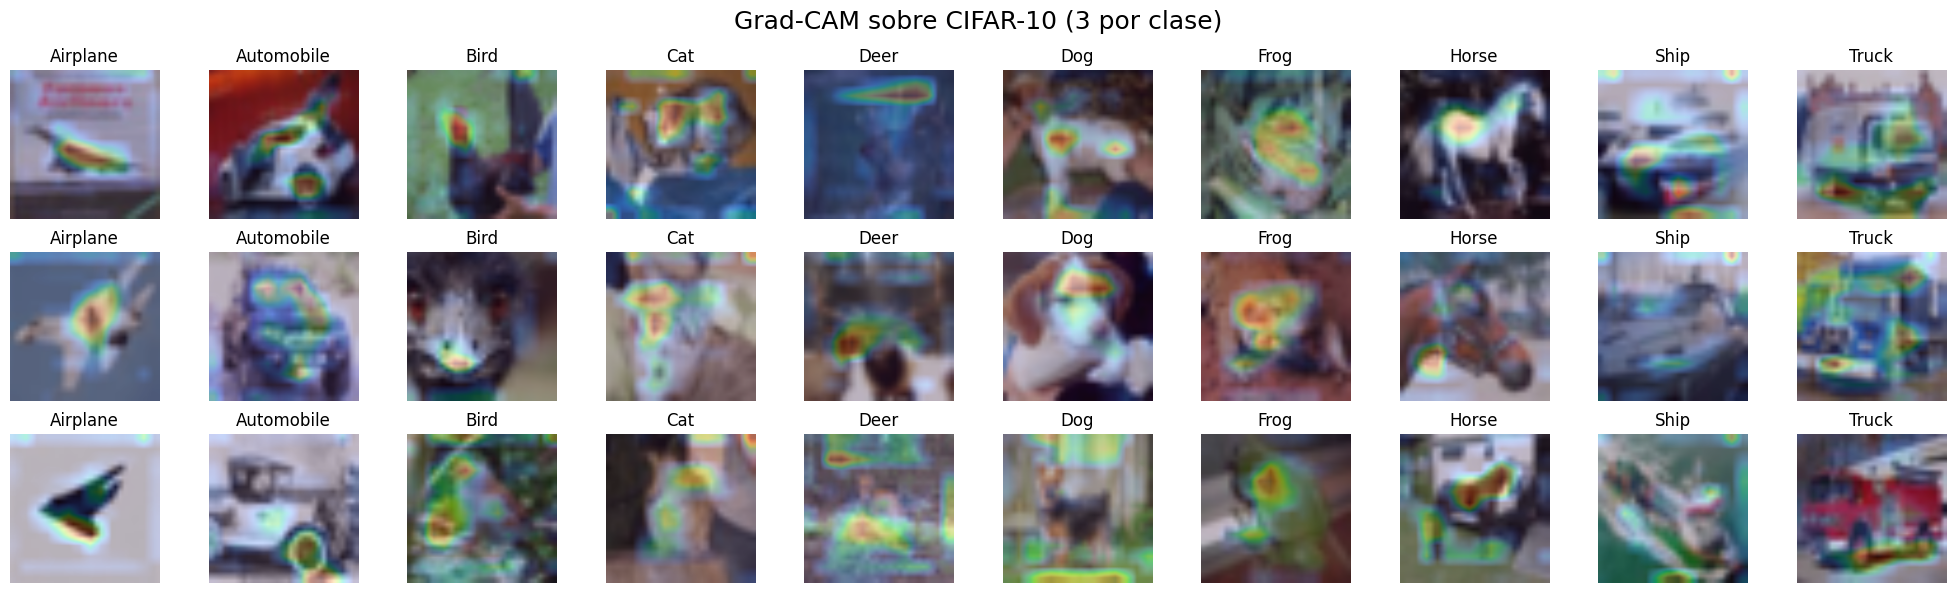

In [45]:
fig, axes = plt.subplots(3, 10, figsize=(20, 6))
fig.suptitle("Grad-CAM sobre CIFAR-10 (3 por clase)", fontsize=18)

imgs_mostradas = {clase: 0 for clase in range(10)}  # clase_idx: count
fila, col = 0, 0

for idx in range(len(X_test)):
    label = np.argmax(Y_test[idx])
    # Checks that only 3 image per class are shown
    if imgs_mostradas[label] >= 3:
        continue

    # Prediction
    img_tensor = tf.convert_to_tensor(X_test[idx], dtype=tf.float32)
    test_img = tf.expand_dims(img_tensor, axis=0)
    test_img = tf.image.resize(test_img, (224, 224))

    gradcam_img = show_gradcam_on_image(test_img, return_only=True)

    ax = axes[imgs_mostradas[label], label]
    ax.imshow(gradcam_img)
    ax.set_title(f"{clases[label]}")
    ax.axis("off")

    imgs_mostradas[label] += 1

    if sum(imgs_mostradas.values()) >= 30:
        break

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

### Análisis crítico

A continuación se procede a analizar las áreas de la imagen que son más importantes para la predicción de cada clase según GradCAM y, detectar qué características parecen estar detectando los mapas de activación.

A simple vista se puede ver lo siguiente:
- **Clase avión**: El modelo predice esta clase cuando en la última capa se activa la detección de halas o formas similares. Además de esto, se puede observar activación en los bordes de las aeronaves, generados por el contraste entre el cielo y el objeto.
- **Clase coche**: Los mapas de activación indican que las reginones de las imágenes que influyen en la predicción de esta clase son las que recogen las ruedas y las ventanas; incluso, en el ejemplo de arriba, parece que la antena del vehículo.
- **Clase pájaro**: Claramente, el modelo determina que se trata de un pájaro a través del área de la imágen que contiene el pico del animal. El modelo ha aprendido que las caracterñisticas que forman el pico tienen una correlación alta con esta clase.
- **Clase gato**: Esta clase es más dificil de interpretar, dada la resolución de las imágenes. Parece que las áreas de la imágen que mas influyen al modelo a la hora de predecir que se trata de un gato corresponden a las orejas y el bigote.
- **Clase ciervo**: Por lo que se consigue observar, las regiones de la imagen que presentan las astas del ciervo presentan una mayor activación.
- **Clase perro**: Al igual que para el gato, no queda del todo claro cuales son las características más influyentes.
- **Clase rana**: Las capas con mayor activación son las que detectan las características de los ojos y los brazos de la rana. Se puede observar como la regisón de la imágen con estos elementos, presentan un gradiente mayor.
- **Clase caballo**: El modelo se fija en la forma que crea el cuello y el lomo del caballo, además de la curvatura de la unión de la cabeza y el cuello del animal.
- **Clase barco**: Por lo que se puede observar, el modelo es influenciado por los bordes que se generan con el contorno del barco.
- **Clase camión**: De la misma manera que el coche, la red identifica las ruedas, la luna delantera y los bordes y formas que genera la parte delantera del camión. En otros ejemplos también se observa mayor activación en las áreas donde se muestra la parte superior del remolque del camión.

b) Interpretación de los resultados: ¿Qué conclusiones se pueden extraer sobre cómo la red
aprendeaidentificarcaracterísticasimportantesenlasimágenes?¿Quéáreasdelaimagen
parecen ser más influyentes en la clasificación? Algunos consejos para responder adecua-
damente a las preguntas:
Basándote en el análisis de los mapas de activación, discute cómo la red aprende a
identificar características importantes en las imágenes.
Explica qué características específicas parecen ser más influyentes en la clasificación
y por qué.
Identifica las áreas de la imagen que parecen ser más influyentes en la clasificación
según los mapas de activación.
Discute si estas áreas coinciden con las características que un observador humano
consideraría importantes para identificar la clase.
Evalúa si los mapas de activación proporcionan una explicación clara y coherente de
las decisiones del modelo.
Discute si hay áreas de la imagen que el modelo parece ignorar pero que podrían ser
importantes para la clasificación.

Las conclusiones que se pueden extraer sobre cómo la red aprende a identificar características importantes en las imágenes son:
- La red no memoriza las imágenes, sino que aprende patrones visuales jerárquicos. En las primeras capas, detecta bordes, texturas y contornos básicos; en capas más profundas, combina estas señales para reconocer estructuras más abstractas o semánticas (como ruedas, los ojos de la rana o alas de avión).

- Al observar los heatmaps se puede concluir que, por ejemplo, en imágenes de camiones, la red tiende a centrar su atención en las ruedas, faros y la cabina frontal, ignorando el fondo. En imágenes de ranas, se activan regiones como los ojos y las patas, y esto coincide bastante con las áreas que un humano también utilizaría para clasificar. Por otro lado, en las aves, el modelo se fija en el pico, lo cual es coherente con características anatómicas distintivas. Aunque, por otro lado, en el caso del caballo, un elemento muy característico es la crin o la cola, y no parece que esto sea una región que influya a la hora de determinar la clase.

Esto indica que la red ha aprendido a enfocar su atención en las partes más discriminativas de cada clase, incluso en presencia de fondos complejos o ruido.

## Conclusiones

A lo largo del proyecto se ha llevado a cabo un proceso progresivo de experimentación con distintos modelos. Inicialmente, se entrenaron redes desde cero, evaluando la arquitectura LeNet con distintas configuraciones. Tras varios experimentos, se seleccionó un modelo con arquitectura LeNet, optimizador Adam y regularización mediante Dropout, que ofreció un accuracy del 69% sobre CIFAR-10. Posteriormente, se aplicó transfer learning sobre la arquitectura VGG16, seguido de una fase de fine-tuning, lo que permitió mejorar significativamente el rendimiento. Este último modelo es el que ha mostrado las mejores métricas de evaluación y ha sido seleccionado para el análisis de interpretabilidad con Grad-CAM.

El uso de Grad-CAM ha permitido visualizar las regiones de la imagen que la red considera más relevantes para cada predicción. En general, se observa que el modelo aprende a enfocar su atención en características discriminativas y coherentes con la percepción humana.

Esta coincidencia sugiere que la red ha captado patrones visuales significativos y toma decisiones basadas en información relevante. Además, los mapas de activación aportan interpretabilidad y ayudan a detectar posibles errores o sesgos, como zonas ignoradas que podrían ser importantes.

En conjunto, Grad-CAM resulta una herramienta valiosa para entender, validar y mejorar modelos de visión por computador, haciendo sus decisiones más transparentes y explicables.